In [6]:
import torch 
import sklearn
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import torchinfo
from tqdm.auto import tqdm

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Method 1 :Popular or not_popular binary classfication

In [34]:
import glob
from pathlib import Path
data_path = Path("./ver1_data/")
image_path = data_path
train_dir = image_path/"train"
test_dir = image_path/"test"
image_path_list = list(Path(image_path).glob("*/*/*"))

In [4]:
def train_step(model, train_dataloader,opt,loss_function, device):
    train_acc = 0
    train_loss = 0
    model.train()
    for x,y in train_dataloader:
        x,y = x.to(device), y.to(device).float()
        pred_y = torch.sigmoid(model(x)).squeeze()
        loss = loss_function(pred_y,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()
        train_acc += (torch.round(pred_y)==y).sum().item()/len(pred_y)
    return train_loss/len(train_dataloader), train_acc/len(train_dataloader)

def test_step(model, test_dataloader, loss_function, device): 
    test_acc = 0
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for x,y in test_dataloader:
            x,y = x.to(device), y.to(device).float()
            pred_y = torch.sigmoid(model(x)).squeeze()
            loss = loss_function(pred_y,y) 
            test_loss += loss.item()
            test_acc += (torch.round(pred_y)==y).sum().item()/len(pred_y)
    return test_loss/len(test_dataloader), test_acc/len(test_dataloader)
def train(epochs, model, train_dataloader, test_dataloader, opt, scheduler, loss_function, device):
    results ={
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          train_dataloader=train_dataloader,
                                          loss_function=loss_function,
                                          opt=opt,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
                                          test_dataloader=test_dataloader,
                                          loss_function=loss_function,
                                          device=device)
        scheduler.step(test_loss)
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

      # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        if (epoch+1)%10 == 0:
            MODEL_PATH = Path("models")
            MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                             exist_ok=True # if models directory already exists, don't error
            )

            # Create model save path
            MODEL_NAME = f"model_{epoch+1}.pth"
            MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

            # Save the model state dict
            print(f"Saving model to: {MODEL_SAVE_PATH}")
            torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
                       f=MODEL_SAVE_PATH)
    return results

In [5]:
train_transform = transforms.Compose([
    transforms.Resize(size=(232,232)),
    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    
])
test_transform = transforms.Compose([
    transforms.Resize(size=(232,232)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [6]:
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform= train_transform,
                                  target_transform=None) 
test_data = datasets.ImageFolder(root = test_dir, transform = test_transform)

In [7]:
test_data.class_to_idx,train_data.class_to_idx

({'not_popular': 0, 'popular': 1}, {'not_popular': 0, 'popular': 1})

In [13]:
weights = torchvision.models.ResNet101_Weights.DEFAULT
transform = weights.transforms()
model = torchvision.models.resnet101(weights =weights)

In [14]:
k = 0
for child in model.children():
    k+=1
    if k<10:
        for param in child.parameters():
            param.requires_grad = False

In [15]:
model.fc = nn.Linear(2048,1)
model = model.to(device)

In [4]:
torchinfo.summary(model, 
        input_size=(32, 3, 232, 232), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [18]:
BATCH_SIZE = 128
LR = 1e-4
EPOCH = 200
train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle=False)
opt = torch.optim.Adam(model.parameters(),lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=10, verbose=True)
loss_function = nn.BCELoss()
results = train(EPOCH, model, train_dataloader, test_dataloader, opt, scheduler, loss_function, device)

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame()
for i in ["train_loss","test_loss","test_acc"]:
    df = pd.concat([df,pd.DataFrame(results[i],columns = [i])],axis=1)

<Axes: >

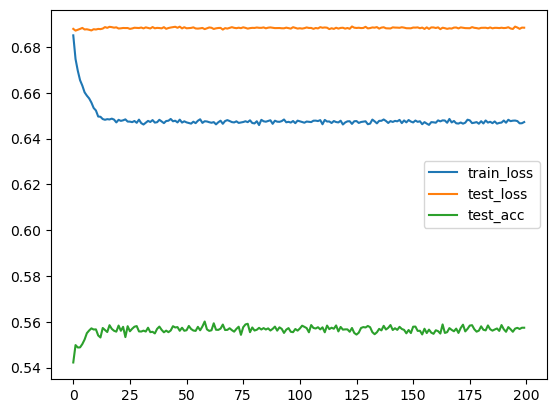

In [43]:
df.plot()

In [3]:
import shutil
import os
for i in ['train','test']:
    for k in range(101):
        if os.path.exists(f"ver4_data/{i}/{k}/.ipynb_checkpoints"):
            shutil.rmtree(f"ver4_data/{i}/{k}/.ipynb_checkpoints")
            print(i,k)



test 1


# Method 2 : Score predict regression

In [16]:
import torch 
import sklearn
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import torchinfo
from tqdm.auto import tqdm
from PIL import Image

In [2]:
import glob
from pathlib import Path
data_path = Path("./ver2_data/")
image_path = data_path
train_dir = image_path/"train"
test_dir = image_path/"test"
image_path_list = list(Path(image_path).glob("*/*/*"))

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
from torch.utils.data import Dataset
def find_label(dir_path):
    return sorted(int(d.name) for d in os.scandir(dir_path) if d.is_dir() )
class CustomDataset(Dataset):
    def __init__(self,dir_path,transform=None):
        self.all_image_path = list(Path(dir_path).glob("*/*"))
        self.transform = transform
        self.label = find_label(dir_path)
    def load_image(self, index):
        image_path = self.all_image_path[index]
        return Image.open(image_path)
    def __len__(self):
        return len(self.all_image_path)
    def __getitem__(self,index):
        image = self.load_image(index)
        label = int(self.all_image_path[index].parent.name)
        img = self.transform(image)
        return img, label

In [5]:
from torchmetrics import R2Score
def train_step(model, train_dataloader,opt,loss_function, device):
    train_r2 = 0
    train_loss = 0
    model.train()
    for x,y in train_dataloader:
        x,y = x.to(device), y.to(device).float()
        pred_y = model(x).squeeze()
        loss = loss_function(pred_y,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()
        r2score = R2Score().to(device)
        score = r2score(pred_y, y)
        train_r2 += score.item()
    return train_loss/len(train_dataloader), train_r2/len(train_dataloader)

def test_step(model, test_dataloader, loss_function, device): 
    test_r2= 0
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for x,y in test_dataloader:
            x,y = x.to(device), y.to(device).float()
            pred_y = model(x).squeeze()
            loss = loss_function(pred_y,y) 
            test_loss += loss.item()
            r2score = R2Score().to(device)
            score = r2score(pred_y, y)
            test_r2 += score.item()
    return test_loss/len(test_dataloader), test_r2/len(test_dataloader)
def train(epochs, model, train_dataloader, test_dataloader, opt, scheduler, loss_function, device):
    results ={
        "train_loss":[],
        "train_r2":[],
        "test_loss":[],
        "test_r2":[]
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_r2 = train_step(model = model,
                                          train_dataloader=train_dataloader,
                                          loss_function=loss_function,
                                          opt=opt,
                                          device=device)
        test_loss, test_r2 = test_step(model = model,
                                          test_dataloader=test_dataloader,
                                          loss_function=loss_function,
                                          device=device)
        scheduler.step(test_loss)
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_r2: {train_r2:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_r2: {test_r2:.4f} "
        )

      # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_r2"].append(train_r2)
        results["test_loss"].append(test_loss)
        results["test_r2"].append(test_r2)
        if (epoch+1)%10 == 0:
            MODEL_PATH = Path("models_score_newversion")
            MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                             exist_ok=True # if models directory already exists, don't error
            )

            # Create model save path
            MODEL_NAME = f"model_{epoch+1}.pth"
            MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

            # Save the model state dicta
            print(f"Saving model to: {MODEL_SAVE_PATH}")
            torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
                       f=MODEL_SAVE_PATH)
    return results

In [6]:
train_transform = transforms.Compose([
    transforms.Resize(size=(232,232)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    
])
test_transform = transforms.Compose([
    transforms.Resize(size=(232,232)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [7]:
train_data = CustomDataset(train_dir, train_transform)
test_data = CustomDataset(test_dir, test_transform)

In [8]:
weights = torchvision.models.ResNet101_Weights.DEFAULT
transform = weights.transforms()
model = torchvision.models.resnet101(weights =weights)
k = 0
for child in model.children():
    k+=1
    if k<10:
        for param in child.parameters():
            param.requires_grad = False
model.fc = nn.Linear(2048,1)
model = model.to(device)

In [17]:
BATCH_SIZE = 256
LR = 1e-4
EPOCH = 150
train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle=False)
opt = torch.optim.Adam(model.parameters(),lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=10, verbose=True)
loss_function = nn.MSELoss()
results = train(EPOCH, model, train_dataloader, test_dataloader, opt, scheduler, loss_function, device)

<Axes: >

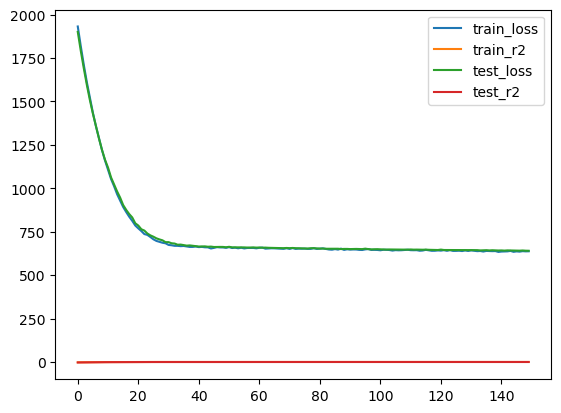

In [15]:
import pandas as pd
pd.DataFrame(results).plot()

# Method 3: Binary classification
### Number of pushes = 0~2為not popular, Number of pushes >50 為popular

In [40]:
import glob
from pathlib import Path
data_path = Path("./ver3_data/")
image_path = data_path
train_dir = image_path/"train"
test_dir = image_path/"test"
image_path_list = list(Path(image_path).glob("*/*/*"))

In [41]:
def train_step(model, train_dataloader,opt,loss_function, device):
    train_acc = 0
    train_loss = 0
    model.train()
    for x,y in train_dataloader:
        x,y = x.to(device), y.to(device).float()
        pred_y = torch.sigmoid(model(x)).squeeze()
        loss = loss_function(pred_y,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()
        train_acc += (torch.round(pred_y)==y).sum().item()/len(pred_y)
    return train_loss/len(train_dataloader), train_acc/len(train_dataloader)

def test_step(model, test_dataloader, loss_function, device): 
    test_acc = 0
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for x,y in test_dataloader:
            x,y = x.to(device), y.to(device).float()
            pred_y = torch.sigmoid(model(x)).squeeze()
            loss = loss_function(pred_y,y) 
            test_loss += loss.item()
            test_acc += (torch.round(pred_y)==y).sum().item()/len(pred_y)
    return test_loss/len(test_dataloader), test_acc/len(test_dataloader)
def train(epochs, model, train_dataloader, test_dataloader, opt, scheduler, loss_function, device):
    results ={
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          train_dataloader=train_dataloader,
                                          loss_function=loss_function,
                                          opt=opt,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
                                          test_dataloader=test_dataloader,
                                          loss_function=loss_function,
                                          device=device)
        scheduler.step(test_loss)
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

      # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        if (epoch+1)%10 == 0:
            MODEL_PATH = Path("models_ver3")
            MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                             exist_ok=True # if models directory already exists, don't error
            )

            # Create model save path
            MODEL_NAME = f"model_{epoch+1}.pth"
            MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

            # Save the model state dict
            print(f"Saving model to: {MODEL_SAVE_PATH}")
            torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
                       f=MODEL_SAVE_PATH)
    return results

In [42]:
train_transform = transforms.Compose([
    transforms.Resize(size=(232,232)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=224, padding=8),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    
])
test_transform = transforms.Compose([
    transforms.Resize(size=(232,232)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [43]:
#path = "data/train or test/popular or not_popular
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform= train_transform,
                                  target_transform=None) 
test_data = datasets.ImageFolder(root = test_dir, transform = test_transform)

In [44]:
weights = torchvision.models.ResNet101_Weights.DEFAULT
transform = weights.transforms()
model = torchvision.models.resnet101(weights =weights)
k = 0
for child in model.children():
    k+=1
    if k<10:
        for param in child.parameters():
            param.requires_grad = False
model.fc = nn.Linear(2048,1)
model = model.to(device)

In [ ]:
BATCH_SIZE = 256
LR = 1e-4
EPOCH = 150
train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle=False)
opt = torch.optim.Adam(model.parameters(),lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=10, verbose=True)
loss_function = nn.BCELoss()
results = train(EPOCH, model, train_dataloader, test_dataloader, opt, scheduler, loss_function, device)

  1%|▎                                                   | 1/150 [02:49<7:01:11, 169.61s/it]

Epoch: 1 | train_loss: 0.6837 | train_acc: 0.5641 | test_loss: 0.6765 | test_acc: 0.6120


  1%|▋                                                   | 2/150 [04:52<5:51:00, 142.30s/it]

Epoch: 2 | train_loss: 0.6640 | train_acc: 0.6195 | test_loss: 0.6652 | test_acc: 0.6401


  2%|█                                                   | 3/150 [06:56<5:28:21, 134.02s/it]

Epoch: 3 | train_loss: 0.6485 | train_acc: 0.6513 | test_loss: 0.6554 | test_acc: 0.6509


  3%|█▍                                                  | 4/150 [09:01<5:16:41, 130.15s/it]

Epoch: 4 | train_loss: 0.6370 | train_acc: 0.6546 | test_loss: 0.6480 | test_acc: 0.6555


  3%|█▋                                                  | 5/150 [11:04<5:08:45, 127.76s/it]

Epoch: 5 | train_loss: 0.6274 | train_acc: 0.6695 | test_loss: 0.6406 | test_acc: 0.6581


  4%|██                                                  | 6/150 [13:07<5:02:41, 126.12s/it]

Epoch: 6 | train_loss: 0.6191 | train_acc: 0.6759 | test_loss: 0.6353 | test_acc: 0.6664


  5%|██▍                                                 | 7/150 [15:11<4:58:34, 125.28s/it]

Epoch: 7 | train_loss: 0.6121 | train_acc: 0.6787 | test_loss: 0.6308 | test_acc: 0.6704


  5%|██▊                                                 | 8/150 [17:14<4:55:21, 124.80s/it]

Epoch: 8 | train_loss: 0.6074 | train_acc: 0.6808 | test_loss: 0.6271 | test_acc: 0.6698


  6%|███                                                 | 9/150 [19:17<4:51:41, 124.13s/it]

Epoch: 9 | train_loss: 0.6024 | train_acc: 0.6835 | test_loss: 0.6229 | test_acc: 0.6690


  7%|███▍                                               | 10/150 [21:21<4:49:30, 124.07s/it]

Epoch: 10 | train_loss: 0.5992 | train_acc: 0.6896 | test_loss: 0.6199 | test_acc: 0.6728
Saving model to: models_ver3/model_10.pth


  7%|███▋                                               | 11/150 [23:25<4:47:04, 123.92s/it]

Epoch: 11 | train_loss: 0.5955 | train_acc: 0.6877 | test_loss: 0.6175 | test_acc: 0.6767


  8%|████                                               | 12/150 [25:28<4:44:40, 123.77s/it]

Epoch: 12 | train_loss: 0.5914 | train_acc: 0.6925 | test_loss: 0.6145 | test_acc: 0.6806


  9%|████▍                                              | 13/150 [27:31<4:41:49, 123.43s/it]

Epoch: 13 | train_loss: 0.5888 | train_acc: 0.6912 | test_loss: 0.6134 | test_acc: 0.6807


  9%|████▊                                              | 14/150 [29:34<4:39:30, 123.31s/it]

Epoch: 14 | train_loss: 0.5874 | train_acc: 0.6951 | test_loss: 0.6105 | test_acc: 0.6812


 10%|█████                                              | 15/150 [31:36<4:36:42, 122.99s/it]

Epoch: 15 | train_loss: 0.5833 | train_acc: 0.6983 | test_loss: 0.6081 | test_acc: 0.6835


 11%|█████▍                                             | 16/150 [33:39<4:34:35, 122.95s/it]

Epoch: 16 | train_loss: 0.5808 | train_acc: 0.7034 | test_loss: 0.6072 | test_acc: 0.6863


 11%|█████▊                                             | 17/150 [35:43<4:33:06, 123.21s/it]

Epoch: 17 | train_loss: 0.5790 | train_acc: 0.7013 | test_loss: 0.6058 | test_acc: 0.6838


 12%|██████                                             | 18/150 [37:46<4:30:56, 123.16s/it]

Epoch: 18 | train_loss: 0.5762 | train_acc: 0.7050 | test_loss: 0.6045 | test_acc: 0.6851


 13%|██████▍                                            | 19/150 [39:50<4:29:33, 123.46s/it]

Epoch: 19 | train_loss: 0.5727 | train_acc: 0.7062 | test_loss: 0.6021 | test_acc: 0.6866


 13%|██████▊                                            | 20/150 [41:53<4:27:19, 123.38s/it]

Epoch: 20 | train_loss: 0.5737 | train_acc: 0.7036 | test_loss: 0.6023 | test_acc: 0.6900
Saving model to: models_ver3/model_20.pth


 14%|███████▏                                           | 21/150 [43:56<4:24:42, 123.12s/it]

Epoch: 21 | train_loss: 0.5713 | train_acc: 0.7107 | test_loss: 0.6006 | test_acc: 0.6905


 15%|███████▍                                           | 22/150 [45:58<4:22:10, 122.89s/it]

Epoch: 22 | train_loss: 0.5683 | train_acc: 0.7111 | test_loss: 0.5999 | test_acc: 0.6886


 15%|███████▊                                           | 23/150 [48:02<4:20:37, 123.13s/it]

Epoch: 23 | train_loss: 0.5690 | train_acc: 0.7088 | test_loss: 0.5982 | test_acc: 0.6910


 16%|████████▏                                          | 24/150 [50:05<4:18:33, 123.12s/it]

Epoch: 24 | train_loss: 0.5664 | train_acc: 0.7114 | test_loss: 0.5980 | test_acc: 0.6911


 17%|████████▌                                          | 25/150 [52:09<4:17:15, 123.49s/it]

Epoch: 25 | train_loss: 0.5666 | train_acc: 0.7081 | test_loss: 0.5968 | test_acc: 0.6924


 17%|████████▊                                          | 26/150 [54:13<4:15:33, 123.66s/it]

Epoch: 26 | train_loss: 0.5657 | train_acc: 0.7090 | test_loss: 0.5961 | test_acc: 0.6927


 18%|█████████▏                                         | 27/150 [56:17<4:13:23, 123.61s/it]

Epoch: 27 | train_loss: 0.5653 | train_acc: 0.7113 | test_loss: 0.5952 | test_acc: 0.6909


 19%|█████████▌                                         | 28/150 [58:20<4:11:12, 123.55s/it]

Epoch: 28 | train_loss: 0.5599 | train_acc: 0.7177 | test_loss: 0.5942 | test_acc: 0.6940


 19%|█████████▍                                       | 29/150 [1:00:24<4:09:34, 123.76s/it]

Epoch: 29 | train_loss: 0.5613 | train_acc: 0.7166 | test_loss: 0.5934 | test_acc: 0.6931


 20%|█████████▊                                       | 30/150 [1:02:27<4:07:09, 123.58s/it]

Epoch: 30 | train_loss: 0.5623 | train_acc: 0.7171 | test_loss: 0.5930 | test_acc: 0.6931
Saving model to: models_ver3/model_30.pth


 21%|██████████▏                                      | 31/150 [1:04:30<4:04:31, 123.29s/it]

Epoch: 31 | train_loss: 0.5592 | train_acc: 0.7199 | test_loss: 0.5920 | test_acc: 0.6939


 21%|██████████▍                                      | 32/150 [1:06:33<4:02:30, 123.31s/it]

Epoch: 32 | train_loss: 0.5602 | train_acc: 0.7142 | test_loss: 0.5915 | test_acc: 0.6938


 22%|██████████▊                                      | 33/150 [1:08:38<4:01:04, 123.62s/it]

Epoch: 33 | train_loss: 0.5583 | train_acc: 0.7172 | test_loss: 0.5912 | test_acc: 0.6927


<Axes: >

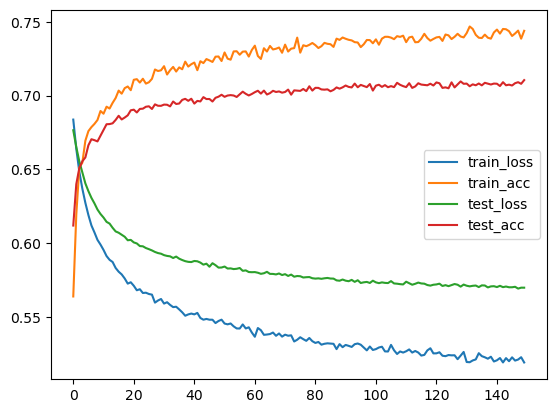

In [49]:
pd.DataFrame(results).plot()

# Model performance evaluation

In [ ]:
import torchvision
import torch
model_2class_path ="./models_ver1/model_150.pth"
model_ver3_path ="./models_ver3/model_150.pth"

model_2class = torchvision.models.resnet101()
k = 0
for child in model_2class.children():
    k+=1
    if k<10:
        for param in child.parameters():
            param.requires_grad = False
model_2class.fc = nn.Linear(2048,1)
model_2class.load_state_dict(torch.load(model_2class_path))
model_2class.to(device)

model_ver3 = torchvision.models.resnet101()
k = 0
for child in model_ver3.children():
    k+=1
    if k<10:
        for param in child.parameters():
            param.requires_grad = False
model_ver3.fc = nn.Linear(2048,1)
model_ver3.load_state_dict(torch.load(model_ver3_path))
model_ver3.to(device)

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize(size=(232,232)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [ ]:
test_dir = "./new_data/test"
test_data_score = CustomDataset(test_dir, transform = test_transform)
test_dataloader = DataLoader(test_data_score, batch_size = 256, shuffle=False)
loss_function = nn.BCELoss()
test_acc = 0
test_loss = 0
model_2class.eval()
with torch.inference_mode():
    for x,y in test_dataloader:
        x,y = x.to(device), y.to(device).float()
        target = change(y)
        target = target.to(device)
        pred_y = torch.sigmoid(model_2class(x)).squeeze()
        loss = loss_function(pred_y,target) 
        test_loss += loss.item()
        
        test_acc += (torch.round(pred_y)==target).sum().item()/len(pred_y)
    print("Avg test_loss:", test_loss/len(test_dataloader))
    print("Avg test_acc:", test_acc/len(test_dataloader))

In [ ]:
test_dir = "./ver3_data/test"
test_data_score = CustomDataset(test_dir, transform = test_transform)
test_dataloader = DataLoader(test_data_score, batch_size = 256, shuffle=False)
loss_function = nn.BCELoss()
test_acc = 0
test_loss = 0
model_ver3.eval()
with torch.inference_mode():
    for x,y in test_dataloader:
        x,y = x.to(device), y.to(device).float()
        pred = model_ver3(x).squeeze()
        tmp = change(pred)
        target = change(y)
        tmp = tmp.to(device)
        target = target.to(device)
        loss = loss_function(tmp,target) 
        test_loss += loss.item()
        test_acc += (torch.round(tmp)==target).sum().item()/len(target)
    print("Avg test_loss:", test_loss/len(test_dataloader))
    print("Avg test_acc:", test_acc/len(test_dataloader))